In [18]:
import os
import numpy as np
import torch
import torchaudio
import pretty_midi
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pretty_midi")

In [19]:
#Loading the files

DATA_DIR = "Audio_Midi_Lyrics"
EMBEDDINGS_DIR = "Embeddings"
file_ids = sorted(list(set(f.split('.')[0] for f in os.listdir(DATA_DIR))))
print(f"Total songs with all 3 formats: {len(file_ids)}")

Total songs with all 3 formats: 50


In [20]:
#Loading and embedding audio with CLAP

from transformers import ClapProcessor, ClapModel

clap_processor = ClapProcessor.from_pretrained("laion/clap-htsat-unfused")
clap_model = ClapModel.from_pretrained("laion/clap-htsat-unfused")

def get_audio_embedding(file_id):
    from transformers import ClapProcessor, ClapModel

    wav_path = os.path.join(DATA_DIR, f"{file_id}.wav")
    audio, sr = torchaudio.load(wav_path)  # shape: [1, N]

    # Ensure mono
    if audio.shape[0] > 1:
        audio = torch.mean(audio, dim=0, keepdim=True)

    # Resample to 48kHz
    if sr != 48000:
        resampler = torchaudio.transforms.Resample(orig_freq=sr, new_freq=48000)
        audio = resampler(audio)

    # Convert to float32
    audio = audio.squeeze().numpy().astype(np.float32)

    # Pass as list
    inputs = clap_processor(audios=[audio], sampling_rate=48000, return_tensors="pt")

    with torch.no_grad():
        audio_emb = clap_model.get_audio_features(**inputs)

    return audio_emb.squeeze().numpy()

In [21]:
#Extracting MIDI Features
def get_midi_features(file_id):
    midi_path = os.path.join(DATA_DIR, f"{file_id}.mid")
    midi = pretty_midi.PrettyMIDI(midi_path)
    notes = [n.pitch for inst in midi.instruments for n in inst.notes if not inst.is_drum]
    if not notes:
        return np.zeros(3)
    tempo = midi.get_tempo_changes()[1].mean() if midi.get_tempo_changes()[1].size > 0 else 120.0
    note_density = len(notes) / midi.get_end_time()
    avg_pitch = np.mean(notes)
    return np.array([tempo, note_density, avg_pitch])

In [22]:
#Embedding lyrics with BERT

lyrics_model = SentenceTransformer("all-MiniLM-L6-v2")

def get_lyrics_embedding(file_id):
    txt_path = os.path.join(DATA_DIR, f"{file_id}.txt")
    with open(txt_path, "r", encoding="utf-8") as f:
        text = f.read()
    return lyrics_model.encode(text)

In [23]:
#Combining all the vectors

def get_full_embedding(file_id):
    audio_emb = get_audio_embedding(file_id)
    midi_emb = get_midi_features(file_id)
    lyrics_emb = get_lyrics_embedding(file_id)
    return np.concatenate([audio_emb, midi_emb, lyrics_emb])

In [24]:
all_embeddings = []
valid_ids = []

for fid in file_ids:
    try:
        vec = get_full_embedding(fid)
        all_embeddings.append(vec)
        valid_ids.append(fid)
    except Exception as e:
        print(f"❌ Skipping {fid}: {e}")

all_embeddings = np.stack(all_embeddings)
np.save("Embeddings/embeddings_full.npy", all_embeddings)    #Edit the text to use the assgined directory name...
np.save("Embeddings/ids_full.npy", valid_ids)                #Edit the text to use the assgined directory name...

print("Embeddings saved in Embeddings folder")    #Edit the text to use the assgined directory name...

Embeddings saved in Embeddings folder


In [25]:
def query_embedding(text_query):
    return lyrics_model.encode(text_query)  # same space as lyrics_emb

def search(query_text, top_k=5):
    print(f"\n🔍 Query: {query_text}")
    q_vec = query_embedding(query_text)
    
    # Extend query to match full vector length (by padding or averaging)
    q_extended = np.concatenate([
        np.zeros(all_embeddings.shape[1] - q_vec.shape[0]),  # pad audio+midi dims
        q_vec
    ])
    
    sims = cosine_similarity(q_extended.reshape(1, -1), all_embeddings)[0]
    top_indices = np.argsort(sims)[::-1][:top_k]
    
    for i, idx in enumerate(top_indices):
        print(f"{i+1}. {valid_ids[idx]}.wav — Similarity: {sims[idx]:.4f}")

In [34]:
print(search("super human"))
print(search("show me loops that feel like heartbreak in spring."))
print(search("bittersweet sunrise"))


🔍 Query: super human
1. 671.wav — Similarity: 0.0016
2. 613.wav — Similarity: 0.0012
3. 064.wav — Similarity: 0.0012
4. 435.wav — Similarity: 0.0011
5. 514.wav — Similarity: 0.0009
None

🔍 Query: show me loops that feel like heartbreak in spring.
1. 522.wav — Similarity: 0.0043
2. 514.wav — Similarity: 0.0033
3. 069.wav — Similarity: 0.0030
4. 246.wav — Similarity: 0.0030
5. 447.wav — Similarity: 0.0024
None

🔍 Query: bittersweet sunrise
1. 069.wav — Similarity: 0.0043
2. 522.wav — Similarity: 0.0032
3. 514.wav — Similarity: 0.0032
4. 536.wav — Similarity: 0.0031
5. 794.wav — Similarity: 0.0028
None


I verified the results by manually performing the search with several queries and comapring the result's lyrics. Its almost there, its somewhere in the ballpark. Let's do some more research......

### Cluster Validation

I will try to plot the embeddings in 2D using TSNE to see if the embeddings are meaningfully organized. We can see if the songs that are kind og similar are organized together.

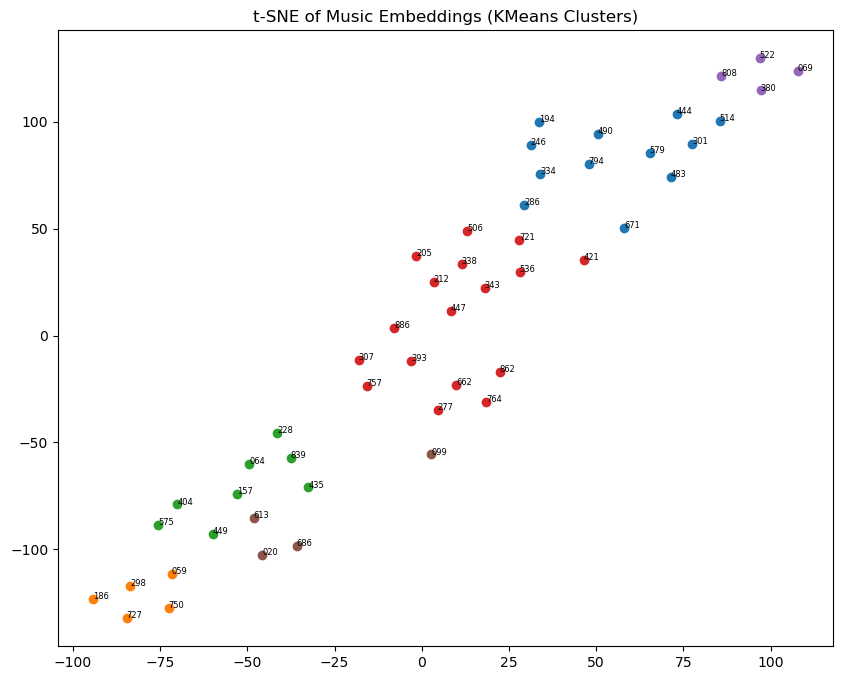

In [27]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, random_state=66).fit(all_embeddings)
cluster_ids = kmeans.labels_

plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(points):
    plt.scatter(x, y, c=f"C{cluster_ids[i]}")
    plt.text(x, y, valid_ids[i], fontsize=6)
plt.title("t-SNE of Music Embeddings (KMeans Clusters)")
plt.show()

They seem to be...

I think the model itself is fine but its only trained on 50 songs that all seem to be about love and breakups (IKR!!). OVERFITTING.....  